# AI supported B&W image colourisation in 5 lines of code (well, kind of)
Author: Krzysztof Drelczuk <br>
https://www.linkedin.com/in/kdrelczuk/ <br>
https://medium.com/@krzysztofdrelczuk

Based on: <br>
https://github.com/richzhang/colorization <br>
https://arxiv.org/pdf/1603.08511.pdf

### Paths

In [2]:
model_url = "http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel"
prototxt_url = "https://raw.githubusercontent.com/richzhang/colorization/master/models/colorization_deploy_v2.prototxt"
pts_url = "https://github.com/richzhang/colorization/blob/master/resources/pts_in_hull.npy?raw=true"
protottxt_path = "colorization_deploy_v2.prototxt"
model_path = "colorization_release_v2.caffemodel"
pts_path = "pts_in_hull.npy"

Path to your image (can be color or grayscale image):

In [3]:
#image_path = "img_seven.jpg"
image_path = "img_bridge.jpg"

### Imports

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors
import urllib
import numpy as np

### Downloading model
Warning! It might take a few mins as the model size is around 130 MB

In [ ]:
urllib.request.urlretrieve(pts_url, pts_path)
urllib.request.urlretrieve(prototxt_url, protottxt_path)
urllib.request.urlretrieve(model_url, model_path)

### Creating model

In [5]:
def model(t):
    net = cv2.dnn.readNetFromCaffe(protottxt_path, model_path)
    pts = np.load(pts_path)

    # 313 - size of (a,b) proaility distibution layer
    # network topolgy: https://arxiv.org/pdf/1603.08511.pdf page 4, fig. 2

    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(class8).blobs = [pts.astype("float32")]

    # T - temperature parameter, originally 0.38 was used then changed to 6/np.log(10)
    # impact of T parameter can be seen at: https://arxiv.org/pdf/1603.08511.pdf page 7, fig. 4
    T = t
    net.getLayer(conv8).blobs = [np.full([1, 313], T, dtype="float32")]
    return net

net = model(6/np.log(10))

## Preparing image

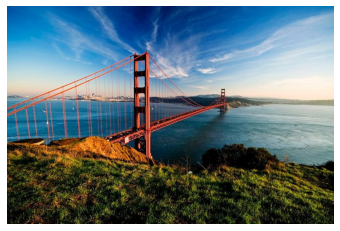

In [15]:
o_image = cv2.imread(image_path)

plt.axis('off')
plt.imshow(o_image[:,:,::-1])

In [16]:
#scale pixels to [0..1] range
scaled = o_image[:,:,::-1].astype("float32") / 255.0

# convert to CIELAB colour space
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

# split CIELAB channels for original image
L_org, a_org, b_org = cv2.split(lab)

# split CIELAB channels for resized (224x224) input image
L_res, a_res, b_res = cv2.split(cv2.resize(lab, (224, 224)))

# subtract 50 for mean-centering have 0 as a mean value 
# L falls between 0 and 100, by substracting 50 it shifts range to -50, 50
L_res -= 50

# get shape of original image
(H, W, C) = o_image.shape

### Plot original images after channel splitting

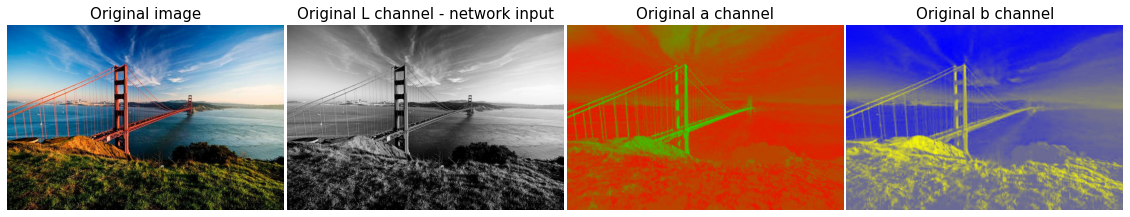

In [17]:
def pseudo_gradient(rgb1, rgb2):
    steps= 256
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2
    rdelta, gdelta, bdelta = (r2-r1)/steps, (g2-g1)/steps, (b2-b1)/steps
    output = []
    for step in range(steps):
        r1 += rdelta
        g1 += gdelta
        b1 += bdelta
        output.append((r1/255, g1/255, b1/255,1))
    return output
    
plt.figure(1, figsize=(20,18))
plt.subplots_adjust(wspace=0.01)

plt.subplot(1,4,1)
plt.axis('off');
plt.title('Original image', fontsize=15)
plt.imshow(o_image[:,:,::-1])

plt.subplot(1,4,2)
plt.axis('off');
plt.title('Original L channel - network input', fontsize=15)
plt.imshow(L_org,cmap="gray");

a_cmap =matplotlib.colors.ListedColormap(pseudo_gradient((255,0,0),(0,255,0)))
b_cmap =matplotlib.colors.ListedColormap(pseudo_gradient((0,0,255),(255,255,0)))

plt.subplot(1,4,3)
plt.axis('off');
plt.title('Original a channel', fontsize=15)
plt.imshow(a_org,cmap=a_cmap)

plt.subplot(1,4,4)
plt.axis('off');
plt.title('Original b channel', fontsize=15)
plt.imshow(b_org,cmap=b_cmap);

### Colourise the image

In [18]:
# 1 -> input L value of resized image into network
net.setInput(cv2.dnn.blobFromImage(L_res))

# 2 -> predict a,b channels
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

# 3-> resize ab to fit original image
ab = cv2.resize(ab, (W, H))

# 4 -> combine original L channel with predicted a, b
outcome = np.concatenate((L_org[:, :, np.newaxis], ab), axis=2)

# 5 -> convert to RGB to display
outcome = cv2.cvtColor(outcome, cv2.COLOR_LAB2RGB)

### Plot results

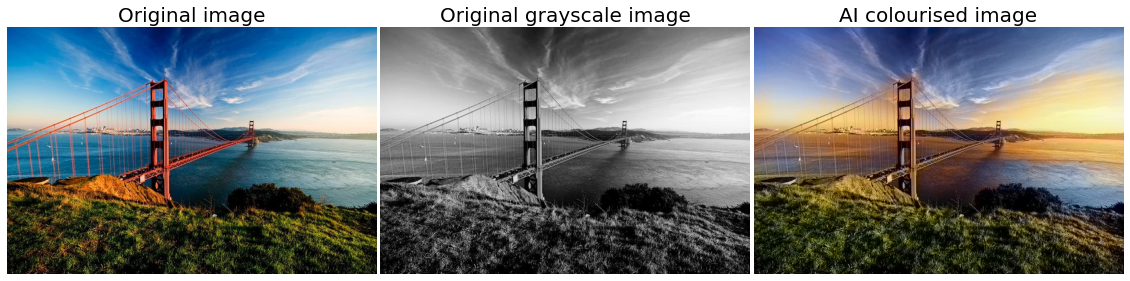

In [19]:
plt.figure(1, figsize=(20,18))
plt.subplots_adjust(wspace=0.01)

plt.subplot(1,3,1)
plt.axis('off');
plt.title('Original image', fontsize=20)
plt.imshow(o_image[:,:,::-1])

plt.subplot(1,3,2)
plt.axis('off');
plt.title('Original grayscale image', fontsize=20)
plt.imshow(L_org,cmap="gray");

plt.subplot(1,3,3)
plt.axis('off');
plt.title('AI colourised image', fontsize=20)
plt.imshow(outcome);